# Introduction

In this assignment, we are going to test different settings in a language model to see how they affect its performance. We wee see how adjusting the attention heads and activation functions will affect the performance, while also seeing how the adjustment of context length affects it.

# Experiment you Ran

In this experiment, I wanted to evaluate how different configurations affect the performance of a language model. I would change the number of attention heads, which could help the model focus on different parts of a sentence. I also adjusted the context length, which helps determine the number of words the model considers at one time. Additionally, I wanted to see the impact of using different activation functions, specifically RELU vs GELU. My goal for this assignment was to see how these changes can influence the model's learning and text prediction capabilities.

## Lab03 Starter Code

In [372]:
!pip install -U datasets

In [373]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

def num_parameters(model):
    """Count the number of trainable parameters in a model"""
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

if False:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu" # with so much overhead in this implementation, GPU doesn't help us much.

We'll use the [TinyStories](https://huggingface.co/datasets/roneneldan/TinyStories) dataset, which is a collection of short stories generated by OpenAI's GPT-3.5. (So don't expect amazing storytelling here.) We'll train the model to predict the next character in the story.

First, we'll take a subset of the dataset for training and validation.

In [374]:
from datasets import load_dataset

dataset = load_dataset("roneneldan/TinyStories", split="train[:30000]")

# make a tiny dataset for experimentation
split_datasets = dataset.train_test_split(test_size=15000, shuffle=False)
train_ds = split_datasets['train']
test_ds = split_datasets['test']
train_ds

Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['text'],
    num_rows: 15000
})

In [375]:
# show an example
example = train_ds[1]
print("Example story:")
print(example['text'])

Example story:
Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.

One day, Beep was driving in the park when he saw a big tree. The tree had many leaves that were falling. Beep liked how the leaves fall and wanted to play with them. Beep drove under the tree and watched the leaves fall on him. He laughed and beeped his horn.

Beep played with the falling leaves all day. When it was time to go home, Beep knew he needed more fuel. He went to the fuel place and got more healthy fuel. Now, Beep was ready to go fast and play again the next day. And Beep lived happily ever after.


## Tokenization

To turn strings into numbers, we'll use the Unicode code point for each character. (To keep things simple, we won't batch anything.)

You don't need to read or understand the code in this section; just run it and look at the results.

In [376]:
n_vocab = 256

def encode_doc(doc):
    token_ids = torch.tensor([ord(x) for x in doc], device=device)
    # Remove any tokens that are out-of-vocabulary
    token_ids = token_ids[token_ids < n_vocab]
    return token_ids

sentence_tensor = encode_doc(example['text'][:50]).cpu() # keep it on CPU for now
sentence_tensor

tensor([ 79, 110,  99, 101,  32, 117, 112, 111, 110,  32,  97,  32, 116, 105,
        109, 101,  44,  32, 116, 104, 101, 114, 101,  32, 119,  97, 115,  32,
         97,  32, 108, 105, 116, 116, 108, 101,  32,  99,  97, 114,  32, 110,
         97, 109, 101, 100,  32,  66, 101, 101])

In [377]:
def decode(x):
    if isinstance(x, torch.Tensor):
        x = x.cpu().numpy()
    return ''.join(chr(x) for x in x)
decode(sentence_tensor)

'Once upon a time, there was a little car named Bee'

In [378]:
# tokenize the dataset
def tokenize_function(examples):
    return dict(
        input_ids=encode_doc(examples["text"])
    )

train_tokenized = train_ds.map(tokenize_function)
train_tokenized.set_format(type='torch', columns=['input_ids'], device=device)

# Each item is now a dictionary with a single key 'input_ids' containing the tokenized text.
example = train_tokenized[1]
example['input_ids'][:10]

tensor([ 79, 110,  99, 101,  32, 117, 112, 111, 110,  32])

In [379]:
print(decode(example['input_ids']))

Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.

One day, Beep was driving in the park when he saw a big tree. The tree had many leaves that were falling. Beep liked how the leaves fall and wanted to play with them. Beep drove under the tree and watched the leaves fall on him. He laughed and beeped his horn.

Beep played with the falling leaves all day. When it was time to go home, Beep knew he needed more fuel. He went to the fuel place and got more healthy fuel. Now, Beep was ready to go fast and play again the next day. And Beep lived happily ever after.


## Multi-Layer Perceptron

## Multi-Layer Perceptron

One of the building blocks of our language model will be a MLP that we looked at in previous notebooks. It will take an input (in "embedding dimension", which we'll define shortly), project it to a hidden space (typically 4 times as wide as the embedding dimension), apply a nonlinearity like ReLU, then project back to the same dimensionality as the input.

Fill in the blanks below to define an MLP as a PyTorch `Module`.

In [380]:
class MLP(nn.Module):
    def __init__(self, emb_dim, n_hidden):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(in_features=emb_dim, out_features=n_hidden),
            nn.ReLU(), # or nn.GELU() or others
            nn.Linear(in_features=n_hidden, out_features=emb_dim)
            # The full Transformer adds some dropout here.
        )

    def forward(self, x):
        return self.model(x)

## A language model with a single MLP

Before we get to the Transformer, we'll start with a simple model that can only look at one token at a time.

At both the input and output of the model, we'll need to translate between the model's internal representation (a vector) and the actual characters. To do this we use *token embeddings*.

We'll use a vocabulary size of 256 (very small, but enough to store individual *bytes*) and an embedding dimensionality of 32 (also pretty small).

In [381]:
emb_dim = 32

Now we'll build this model. Skim this code, but we'll come back and delve into it more, so don't worry if you don't understand everything right away.

In [382]:
class FeedForwardLM(nn.Module):
    def __init__(self, n_vocab, emb_dim, n_hidden):
        super().__init__()
        self.word_to_embedding = nn.Embedding(n_vocab, emb_dim)
        self.model = MLP(emb_dim=emb_dim, n_hidden=n_hidden)
        self.lm_head = nn.Linear(emb_dim, n_vocab, bias=False)

        # Use the token embeddings for the LM head ("tie weights")
        assert self.lm_head.weight.shape == self.word_to_embedding.weight.shape
        self.lm_head.weight = self.word_to_embedding.weight
    
    def forward(self, input_ids):
        # This method gets called when we "call" the model object on some input data.
        input_embeds = self.word_to_embedding(input_ids)
        x = self.model(input_embeds)
        return self.lm_head(x)

Let's train this overly-simple model and see what it learns.

The feed-forward-only LM has 16544 parameters
Epoch 0, Loss: 2.3259195924917857
Epoch 1, Loss: 2.3015279942671456
Epoch 2, Loss: 2.2994297406514486
Epoch 3, Loss: 2.2986504335244495
Epoch 4, Loss: 2.298129186121623


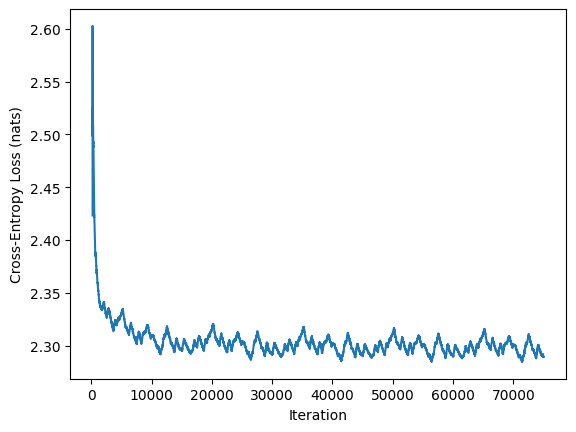

In [383]:
# Let's train the model
model = FeedForwardLM(n_vocab=n_vocab, emb_dim=emb_dim, n_hidden=emb_dim * 4)
print(f"The feed-forward-only LM has {num_parameters(model)} parameters")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []

for epoch in range(5):
    sample_counter = 0 
    for example in train_tokenized:
        token_ids = example['input_ids']
        assert token_ids.max() < n_vocab

        # set up a causal language modeling task:
        # each token should be predicted using the tokens before it
        input_ids = token_ids[:-1]
        targets   = token_ids[1:]

        logits = model(input_ids)
        loss = nn.CrossEntropyLoss()(logits, targets)

        # Do gradient descent and keep track of the loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        sample_counter += 1

    avg_loss_this_epoch = sum(losses[-sample_counter:]) / sample_counter
    print(f"Epoch {epoch}, Loss: {avg_loss_this_epoch}")


# Plot a smoothed version of the loss (easier to see the trend)
pd.Series(losses)[200:].ewm(alpha = .001).mean().plot()
plt.xlabel('Iteration')
plt.ylabel("Cross-Entropy Loss (nats)");

(n## Trace the Simple Model

We'll now go through the model's forward pass, step by step, to see how it processes a single character.

In [384]:
# Look at the example again; just the first 10 tokens to keep it simple.
example = train_tokenized[1]
token_ids = example['input_ids'][:10]
print(decode(token_ids))

Once upon 


We'll make this an autoregressive language model, so our goal will be to predict the next character. So we'll need to shift the targets left, so each character should output the next one.

In [385]:
input_ids = token_ids[:-1]
targets   = token_ids[1:]
assert input_ids.shape == targets.shape

print("Inputs: ", decode(input_ids))
print("Targets:", decode(targets))

Inputs:  Once upon
Targets: nce upon 


### Step 1: Embeddings

We'll be working through the `forward` method step by step. The first step is to embed the input character. The `word_to_embedding` module is just a lookup table that maps each possible character to a (learned) 32-dimensional vector.

In [386]:
token_embedding_table = model.word_to_embedding.weight
tuple(token_embedding_table.shape)

(256, 32)

In [387]:
print("Input ids shape:", tuple(input_ids.shape))
input_embeds = model.word_to_embedding(input_ids)
print("Input embeddings shape:", tuple(input_embeds.shape))

Input ids shape: (9,)
Input embeddings shape: (9, 32)


### Step 2: MLP

Now we pass the embedding through the MLP. First, project the inputs to the hidden layer:

In [388]:
mlp = model.model
mlp_hidden_layer = mlp.model[0](input_embeds)
print("MLP hidden layer shape:", tuple(mlp_hidden_layer.shape))
print("Min value of the hidden layer:", mlp_hidden_layer.min().item())

MLP hidden layer shape: (9, 128)
Min value of the hidden layer: -2.489581346511841


Then apply the activation function(ReLU):

In [389]:
mlp_hidden_activations = mlp.model[1](mlp_hidden_layer)
print("MLP hidden activations shape:", tuple(mlp_hidden_activations.shape))
print("Min value of the activations:", mlp_hidden_activations.min().item())

MLP hidden activations shape: (9, 128)
Min value of the activations: 0.0


Then project back to the embedding dimension:

In [390]:
mlp_output = mlp.model[2](mlp_hidden_activations)
print("MLP output shape:", tuple(mlp_output.shape))

MLP output shape: (9, 32)


### Step 3: LM Head

The MLP outputs are now the context embeddings. To turn them into predictions for the next character, we'll pass them through the LM head (which is just a linear layer):

In [391]:
lm_head = model.lm_head
lm_logits = lm_head(mlp_output)

# Since the weights are tied, this is the same thing as mlp_output @ token_embedding_table.T

In [392]:
print("Logits Shape: ", tuple(lm_logits.shape))

Logits Shape:  (9, 256)


The shape of the logits tensor is (9, 256). The 9 represents the amount of predictions for each input token. And each prediction is represented by a vector of length 256.

In [393]:
for i in range(len(input_ids)):
    print(f"Token: {decode(input_ids[i:i+1])}; Most likely next token:", decode([lm_logits[i].argmax()]))

Token: O; Most likely next token: n
Token: n; Most likely next token: d
Token: c; Most likely next token: e
Token: e; Most likely next token:  
Token:  ; Most likely next token: t
Token: u; Most likely next token: t
Token: p; Most likely next token: p
Token: o; Most likely next token:  
Token: n; Most likely next token: d


Here's how we compute the cross-entropy loss between the predicted and actual next characters. (In PyTorch, the `CrossEntropyLoss` function combines the softmax and the negative log likelihood loss, i.e., it expects to be given *logits*, not probabilities.)

In [394]:
loss = nn.CrossEntropyLoss()(lm_logits, targets)
loss

tensor(2.0476, grad_fn=<NllLossBackward0>)

## Generating text

In [395]:
prompt = 'A'
prompt_tensor = encode_doc(prompt)
prompt_tensor

tensor([65])

In [396]:
prompt_tensor = encode_doc('A')
temperature = 0.5
for i in range(100):
    logits = model(prompt_tensor)
    # Get the next-token logits
    next_token_logits = logits[-1]
    # Scale the logits by the temperature
    scaled_logits = next_token_logits / temperature
    # Apply softmax to get probabilities
    probs = scaled_logits.softmax(dim=-1)
    # sample from the probability distribution
    next_token = torch.multinomial(probs, num_samples=1)
    # append the token to the prompt tensor
    prompt_tensor = torch.cat([prompt_tensor, next_token])

# Show the generated text
print("'" + decode(prompt_tensor)+ "'")

'And e outhe The o bind t be thithere tom whe ther wan ted he ary ppupy he a to she o ce wane the an a'


## Self-Attention

To make better predictions, we'll need to let the model look at more than just one token at a time. We'll do this with *self-attention*. The idea is that each token can look at all the other tokens and decide how much to pay attention to each one. This is a powerful mechanism that allows the model to learn dependencies between tokens that are far apart. (For example, in the sentence "I grew up in France... I speak fluent French", the word "French" is highly dependent on the word "France", but they're far apart in the sentence.)

In the last year, billions of computing dollars have been spent on training and running models that are basically just stacks of self-attention layers like what we'll implement in this section. It's a very powerful idea! (It even made the predictions that I accepted to type in more than half of the words in the previous paragraph, haha!)

We're going to implement an oversimplified Self-Attention layer. If you're interested, here are a few reference implementations of the real thing:

- https://github.com/jaymody/picoGPT/ (ridiculously compact)
- [minGPT](https://github.com/karpathy/minGPT/blob/master/mingpt/model.py) (more readable)
- https://github.com/karpathy/nanoGPT/blob/master/model.py (more brrr)
- [Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
- PyTorch's builtin implementation: [`TransformerEncoderLayer`](https://pytorch.org/docs/stable/_modules/torch/nn/modules/transformer.html#TransformerEncoderLayer) and [`MultiheadAttention`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html#torch.nn.MultiheadAttention).

### Generating text
We'll start with a big pile of code, then pull it apart step by step. So *run this code first*, then we'll come back to try to understand it. (It'll take a bit longer to train, too, so get the training cell started while you read the code.)

In [397]:
VERY_SMALL_NUMBER = -1e9
def make_causal_mask(sequence_len):
    return (1 - torch.tril(torch.ones(sequence_len, sequence_len))) * VERY_SMALL_NUMBER

class BareBonesAttentionHead(nn.Module):
    '''Implements *single-head* attention, no dropout, no init'''
    def __init__(self, emb_dim, head_dim):
        super().__init__()
        self.head_dim = head_dim
        self.get_query = nn.Linear(emb_dim, head_dim, bias=False)
        self.get_key = nn.Linear(emb_dim, head_dim, bias=False)
        self.get_value = nn.Linear(emb_dim, head_dim, bias=False)

    def forward(self, x):
        seq_len, emb_dim = x.shape

        # Compute query, key, and value vectors.
        q = self.get_query(x) # (seq_len, head_dim)
        k = self.get_key(x)
        v = self.get_value(x)

        # Compute attention weights.
        k_transpose = k.transpose(-2, -1)
        assert k_transpose.shape == (self.head_dim, seq_len)
        scores = q @ k_transpose  / emb_dim**0.5
        assert scores.shape == (seq_len, seq_len)
        # Apply the causal mask
        causal_mask = make_causal_mask(seq_len).to(scores.device)
        scores = scores + causal_mask
        attention_weights = scores.softmax(dim=-1)
        # The full Transformer adds some dropout here.

        # Compute weighted sum of values.
        out = attention_weights @ v
        return out

class BareBonesSelfAttention(nn.Module):
    def __init__(self, emb_dim, head_dim, n_heads):
        super().__init__()
        self.heads = nn.ModuleList([
            BareBonesAttentionHead(emb_dim, head_dim)
            for i in range(n_heads)
        ]) # we need a ModuleList to make sure the heads are counted as children.
        # This last linear layer projects concatenated embeddings back to the original embedding space.
        # It's not strictly necessary; you could premultiply it with the get_value matrices.
        self.to_output = nn.Linear(n_heads * head_dim, emb_dim, bias=False)

    def forward(self, x):
        head_outputs = [head(x) for head in self.heads]
        concats = torch.cat(head_outputs, dim=-1)
        out = self.to_output(concats)
        assert out.shape == x.shape
        return out

Now we'll define a Transformer. Well, we'll just define a single layer. A true Transformer will have many (perhaps 32, 64, 118, ...) such layers. But it's just running a bunch of instances of a layer like this in sequence.

One new thing here is the *layer norm*. It basically rescales the activations to be mean 0 variance 1, then scales and shifts by learnable constants. So each one adds 2 * emb_dim parameters to the model, and there's one after each part (self-attention and MLP).

In [398]:
class BareBonesTransformerLayer(nn.Module):
    '''Implements bare-bones self-attention transformer layer, no residual connections, no dropout'''
    def __init__(self, emb_dim, head_dim, n_heads, dim_feedforward):
        super().__init__()
        self.self_attention = BareBonesSelfAttention(emb_dim, head_dim=head_dim, n_heads=n_heads)
        self.mlp = MLP(emb_dim, n_hidden=dim_feedforward)
        self.norm_1 = nn.LayerNorm(emb_dim)
        self.norm_2 = nn.LayerNorm(emb_dim)
    
    def forward(self, x):
        x = x + self.self_attention(self.norm_1(x))
        x = x + self.mlp(self.norm_2(x))
        return x

xformer_layer = BareBonesTransformerLayer(emb_dim, dim_feedforward=emb_dim, head_dim=256, n_heads=2)

Now, at long last, let's make a complete Transformer-based language model.

A big new aspect here is the *position embeddings*. We'll implement *learned absolute position embeddings*, which do add parameters to the model. (A cool new approach, called *Rotary Position Embeddings* ([RoPE](https://blog.eleuther.ai/rotary-embeddings/)), gets comparable or better performance without adding parameters; most current models, like Llama2 and Gemma, use it.)

In [408]:
class TransformerLM(nn.Module):
    def __init__(self, n_vocab, max_len, emb_dim, n_hidden, head_dim=5, n_heads=8):
        super().__init__()
        self.max_len = max_len
        self.word_to_embedding = nn.Embedding(n_vocab, emb_dim)
        self.pos_to_embedding = nn.Embedding(max_len, emb_dim)
        self.model = BareBonesTransformerLayer(
            emb_dim=emb_dim, dim_feedforward=n_hidden,
            head_dim=head_dim, n_heads=n_heads)
        self.lm_head = nn.Linear(emb_dim, n_vocab, bias=False)

        assert self.lm_head.weight.shape == self.word_to_embedding.weight.shape
        self.lm_head.weight = self.word_to_embedding.weight
    
    def forward(self, input_ids):
        seq_len = input_ids.shape[-1]
        if seq_len > max_len:
            # Fail if the input sequence is too long.
            raise ValueError(f"Input sequence length {seq_len} is longer than the maximum of {max_len}")
        input_embeds = self.word_to_embedding(input_ids)
        # Compute position embeddings.
        position_ids = torch.arange(seq_len, device=input_ids.device)
        pos_embeds = self.pos_to_embedding(position_ids)
        x = input_embeds + pos_embeds
        x = self.model(x)
        return self.lm_head(x)

### Train the Transformer

Now let's try training that model. Run this code, it'll take a minute or two.

Epoch 0, Loss: 1.9755525397698084
Epoch 1, Loss: 1.423974456646045
Epoch 2, Loss: 1.1666149586121242
Epoch 3, Loss: 1.075637094803651
Epoch 4, Loss: 1.0276251608620088


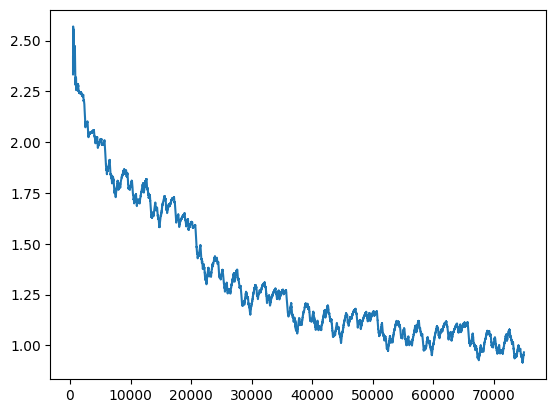

In [409]:
# Set up a single-head model so it's easier to trace. Later you can try more heads.
context_length = 100
model = TransformerLM(n_vocab=n_vocab, max_len=max_len, emb_dim=emb_dim, n_hidden=emb_dim * 4, head_dim=emb_dim // 2, n_heads=8)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []

for epoch in range(5):
    sample_counter = 0
    for example in train_tokenized:
        # Truncate the example to the context length of the model.
        token_ids = example['input_ids'][:max_len]
        input_ids = token_ids[:-1]
        targets = token_ids[1:]

        assert token_ids.max() < n_vocab

        logits = model(input_ids)
        loss = nn.CrossEntropyLoss()(logits, targets)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        sample_counter += 1
    avg_loss_this_epoch = sum(losses[-sample_counter:]) / sample_counter
    print(f"Epoch {epoch}, Loss: {avg_loss_this_epoch}")

# Plot a smoothed version of the loss (easier to see the trend)
pd.Series(losses)[500:].ewm(alpha = .001).mean().plot();

## Loss on Unseen Data

In [410]:
# Tokenize the test dataset
test_tokenized = test_ds.map(tokenize_function)
test_tokenized.set_format(type='torch', columns=['input_ids'], device=device)

# Evaluate the model on the test dataset
test_losses = []
with torch.no_grad():
    for example in test_tokenized:
        token_ids = example['input_ids'][:max_len]
        input_ids = token_ids[:-1]
        targets = token_ids[1:]

        logits = model(input_ids)
        loss = nn.CrossEntropyLoss()(logits, targets)
        test_losses.append(loss.item())

# Calculate average loss and perplexity on the test dataset
avg_test_loss = sum(test_losses) / len(test_losses)
test_perplexity = torch.exp(torch.tensor(avg_test_loss))
print(f"Average test loss: {avg_test_loss:.4f}")
print(f"Test perplexity: {test_perplexity:.4f}")

Average test loss: 1.0627
Test perplexity: 2.8943


## Generating Text/Sentences

In [318]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [319]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [320]:
attention_heads = [1, 2, 4, 8]
models = {heads: TransformerModel(emb_size=512, n_heads=heads, num_layers=6) for heads in attention_heads}

In [327]:
def generate_text(model, start_seq, length, temperature=1.0):
    model.eval()
    input_ids = torch.tensor([ord(c) for c in start_seq], dtype=torch.long).unsqueeze(0).to(device)  # Convert start sequence to tensor
    
    with torch.no_grad():
        for _ in range(length):
            outputs = model(input_ids)
            predictions = outputs[:, -1, :]
            predictions = predictions / temperature  # Apply temperature scaling
            probs = torch.nn.functional.softmax(predictions, dim=-1)
            next_char = torch.multinomial(probs, num_samples=1)
            input_ids = torch.cat([input_ids, next_char], dim=1)
    
    generated_text = ''.join([chr(int(i)) for i in input_ids[0]])
    return generated_text

In [344]:
def analyze_text(text):
    words = text.split()
    sentences = sent_tokenize(text)
    avg_word_length = np.mean([len(word) for word in words]) if words else 0
    avg_sentence_length = np.mean([len(sentence.split()) for sentence in sentences]) if sentences else 0
    return avg_word_length, avg_sentence_length

def evaluate_models(models):
    results = []
    for heads, model in models.items():
        model.to(device)
        generated_text = generate_text(model, "Hello ", 200)  # Example starting sequence
        avg_word_length, avg_sentence_length = analyze_text(generated_text)
        results.append({
            'num_heads': heads,
            'avg_word_length': avg_word_length,
            'avg_sentence_length': avg_sentence_length
        })
        print(f"Num Heads: {heads}, Avg Word Length: {avg_word_length:.2f}, Avg Sentence Length: {avg_sentence_length:.2f}")
    return results

results = evaluate_models(models)

Num Heads: 1, Avg Word Length: 68.00, Avg Sentence Length: 3.00
Num Heads: 2, Avg Word Length: 24.88, Avg Sentence Length: 8.00
Num Heads: 4, Avg Word Length: 33.33, Avg Sentence Length: 6.00
Num Heads: 8, Avg Word Length: 33.50, Avg Sentence Length: 6.00


# Plot Diagrams

## Exploring Model Configurations: X-Axis Measurements

### Adjusting Amount of Attention Heads

<Axes: xlabel='num_heads'>

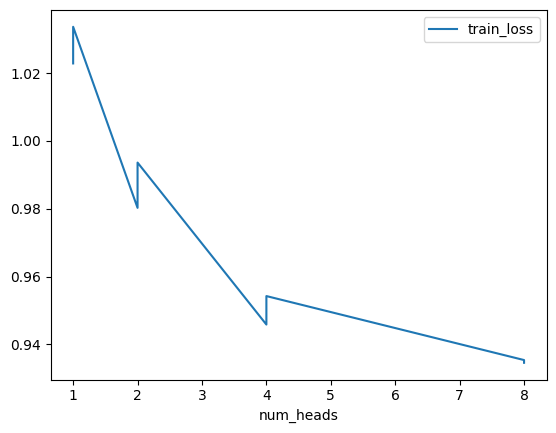

In [412]:
import matplotlib.pyplot as plt
import pandas as pd

results = [
  {"num_heads": 1, "train_loss": 1.022863831922412},
  {"num_heads": 1, "train_loss": 1.0336742574185134},
  {"num_heads": 2, "train_loss": 0.9802694233174125},
  {"num_heads": 2, "train_loss": 0.9936278161942959},
  {"num_heads": 4, "train_loss": 0.9458598273227612},
  {"num_heads": 4, "train_loss": 0.9542624862715602},
  {"num_heads": 8, "train_loss": 0.9353901456281543},
  {"num_heads": 8, "train_loss": 0.9345866645852725},
]
results_df = pd.DataFrame(results)
results_df.plot(x="num_heads", y="train_loss")

### Adjusting Context Length

<Axes: xlabel='max_length'>

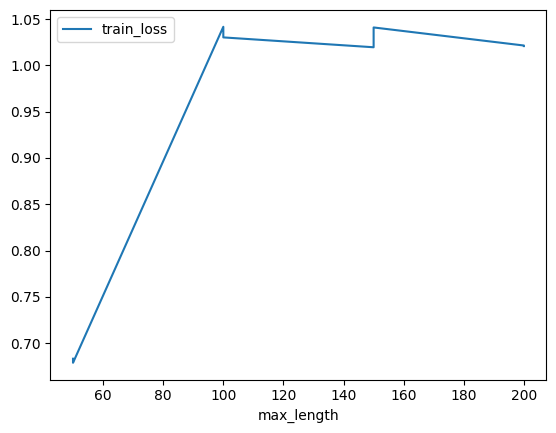

In [413]:
results = [
  {"max_length": 50, "train_loss": 0.6832503506333257},
  {"max_length": 50, "train_loss": 0.6788563627236213},
  {"max_length": 100, "train_loss": 1.0416479911456507},
  {"max_length": 100, "train_loss": 1.0301824082881212},
  {"max_length": 150, "train_loss": 1.0195330026139815},
  {"max_length": 150, "train_loss": 1.0409252572069565},
  {"max_length": 200, "train_loss": 1.0214159949262938},
  {"max_length": 200, "train_loss": 1.0208098627020916},
]
results_df = pd.DataFrame(results)
results_df.plot(x="max_length", y="train_loss")

### RELU VS GELU

<Axes: title={'center': 'GeLU'}, xlabel='num_heads'>

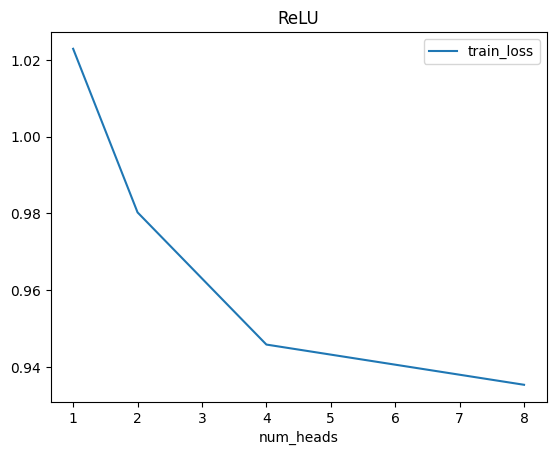

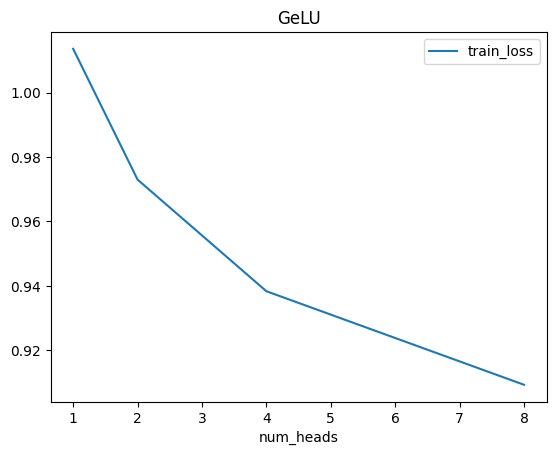

In [414]:
import matplotlib.pyplot as plt
import pandas as pd

results_relu = [
  {"activation": "RELU", "num_heads":1, "train_loss": 1.022863831922412},
  {"activation": "RELU", "num_heads":2, "train_loss": 0.9802694233174125},
  {"activation": "RELU", "num_heads":4, "train_loss": 0.9458598273227612},
  {"activation": "RELU", "num_heads":8, "train_loss": 0.9353901456281543},
]

results_gelu = [
  {"activation": "GELU", "num_heads":1, "train_loss": 1.0135790634493034},
  {"activation": "GELU", "num_heads":2, "train_loss": 0.9729865694209934},
  {"activation": "GELU", "num_heads":4, "train_loss": 0.9383438150172432},
  {"activation": "GELU", "num_heads":8, "train_loss": 0.9093157674764594},
]

results_df_relu = pd.DataFrame(results_relu)
results_df_gelu = pd.DataFrame(results_gelu)

results_df_relu.plot(title="ReLU", x="num_heads", y="train_loss")
results_df_gelu.plot(title="GeLU",x="num_heads", y="train_loss")


## Exploring Model Configuraton: Y-Axis Adjustments

### Perplexity on unseen data

<Axes: title={'center': 'Perplexity on Unseen Data'}, xlabel='num_heads'>

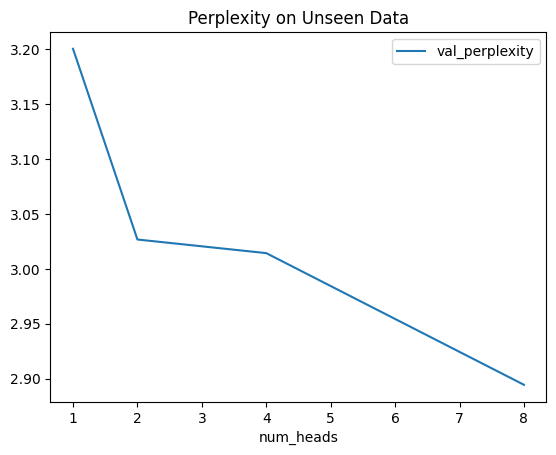

In [415]:
results = [
  {"num_heads": 1, "val_perplexity": 3.2003},
  {"num_heads": 2, "val_perplexity": 3.0266},
  {"num_heads": 4, "val_perplexity": 3.0142},
  {"num_heads": 8, "val_perplexity": 2.8943}
]

results_df = pd.DataFrame(results)
results_df.plot(title="Perplexity on Unseen Data", x="num_heads", y="val_perplexity")

### Average length of words / sentences generated

<Axes: xlabel='num_heads'>

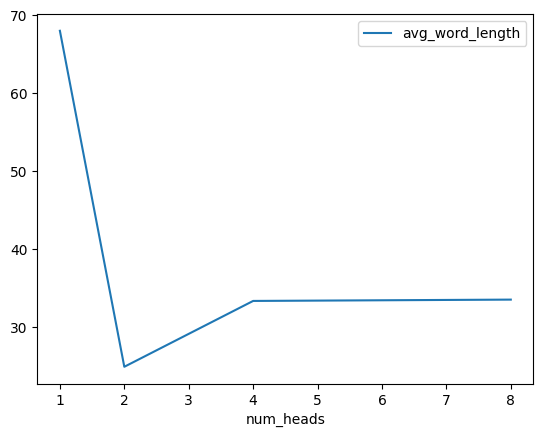

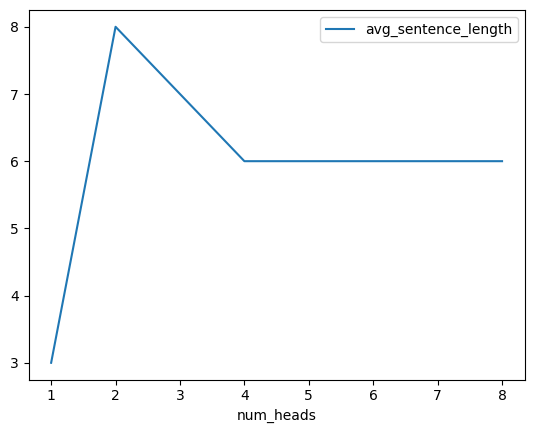

In [416]:
'''
Num Heads: 1, Avg Word Length: 68.00, Avg Sentence Length: 3.00
Num Heads: 2, Avg Word Length: 24.88, Avg Sentence Length: 8.00
Num Heads: 4, Avg Word Length: 33.33, Avg Sentence Length: 6.00
Num Heads: 8, Avg Word Length: 33.50, Avg Sentence Length: 6.00
'''

results_word_length = [
  {"num_heads": 1, "avg_word_length": 68.0},
  {"num_heads": 2, "avg_word_length": 24.88},
  {"num_heads": 4, "avg_word_length": 33.33},
  {"num_heads": 8, "avg_word_length": 33.50}
]

results_sentence_length = [
  {"num_heads": 1, "avg_sentence_length": 3.0},
  {"num_heads": 2, "avg_sentence_length": 8.0},
  {"num_heads": 4, "avg_sentence_length": 6.0},
  {"num_heads": 8, "avg_sentence_length": 6.0}
]

results_df = pd.DataFrame(results_word_length)
results_df.plot(x="num_heads", y="avg_word_length")

results_df = pd.DataFrame(results_sentence_length)
results_df.plot(x="num_heads", y="avg_sentence_length")

# Interpretation

## X-axis
### Adjusting the Amount of Attention Heads
From adjusting the amount of attention heads in the model,the results were able to show a very clear trend. As the number of attentiion heads increased, the training loss would usually decrease. From this trend, it suggests taht having more attention heads tends to help the model better understand and predict the text, which would then help improve performance.

### Adjusting the Context Length

By adjusting the context length in the model shows that as the context length increases, the training loss initially increases but tends to plateau. Using shorter context lengths, such as 50 characters, the model achieves lower training losses, suggesting it handles smaller sequences more efficiently. Although the training loss increases with longer context lengths, it stabilizes after reaching a certain point, indicating that while longer sequences might be more challenging, the model can consistently manage them beyond a certain threshold.

### RELU vs GELU

By testing different numbers of attention heads with ReLU and GELU activations show that as the number of attention heads increases, the training loss decreases for both activation functions. This suggests that models with more attention heads are better at learning from the training data. Additionally, the models using GELU activation consistently achieve lower training losses compared to those using ReLU, indicating that GELU might be a more effective activation function for this specific task.

## Y-axis

### Perplexity on Unseen Data

Looking at the results, we can see that the perplexity on unseen data generally decreases as the number of attention heads in the model increases. This might tell us that having more attentioin heads helps the model better understand and predict the next word in a sequence, which improves the performance.

### Average Length of Words or Sentences Generated

These results show how changing the number of attention heads in the model affect the average word and sentence length in the genereated text. At first, with a lower attention head amount, the model tended to generate really long words but shorter sentences. As we increased the number of heads, the average word and sentence length tended to be very similar. This shows that past a certain threshold, adjusting the amount of attention head might not change how the model generates text.

# Conclusion

From this experimentation, we tried to see how change the number of attention heads, the context length, and the type of activatiion functiosn affects the performance of a language model. From these experiments, we saw that adding more attention heads would generally make the model better at understanding and predicting text. This was because it would provide us with lower training losses and better performance on unseen data. We also tried to compare two different activation function with ReLU vs GeLU. From this, we found that GeLU would generally perform better. We also increased the context length which initally made the model not perform too well but it improved as the context length got longer. This experiment displayed how minor changes can impact how the model learns and predicts.